# You Do Not Need a Vector Database

First, some quick background. The large language models (LLMs) like GPT, Llama, etc all take a limited amount of context (16k tokens). As such if I want to use an LLM to perform question answering on a very large collection of documents, we cannot simply stuff all the documents into the context. While one could fine-tune the LLM on the set of documents, this is difficult and costly if the set of documents change very quickly. For instance, I have fantasized about running Llama on my laptop so I can easily find emails, documents, etc, and I certainly do want to finetune an LLM for every email I receive.

Retrieval Augmented Generation (RAG) has risen as a solution where you first try to find a small set of relevant documents that will help answer the question, and stuff just those documents into the context. A popular way to find these set of relevant documents is to compute a vector embedding of each document, which is a representation of the "meaning" of the document; documents which are similar semantically, should have vectors which are close. Then given a question, we  compute a vector embedding of the question and use nearest neighbor search to find the most relevant documents.

Vector databases have risen in popularity lately as a means of storing and computing nearest neighbor on a large collection of documents. However, I argue that you almost never need a vector database.

The task of finding a small set of documents that answers a given question is basically that of Information Retrieval, and very much predates vector databases. The most obvious forms of such systems which you interact with on a daily basis, are search engines (Google, Bing, Apache Lucene, Apple Spotlight, and many others). Of which highly scalable technologies such as reverse indexes are well known, highly available, and have been well developed over decades of research and engineering. Here, I will attempt to demonstrate why you probably do not need a vector database, and maybe some circumstances in which you might.

# Dataset
First, I need a benchmark dataset for document retrieval for the purposes of question answering. Here, we (mis)use the [SQuAD dataset](https://rajpurkar.github.io/SQuAD-explorer/).

The SQuAD dataset comprises of a collection of paragraphs, and questions for each paragraph. Each question is meant to answered only by information found in the paragraph. 
For instance a paragraph might be:
```
Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager. Beyoncé\'s name is a tribute to her mother\'s maiden name. Beyoncé\'s younger sister Solange is also a singer and a former member of Destiny\'s Child. Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry). Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard. She was raised in a Methodist household.
```

And a few questions for this paragraph are:
 - What race was Beyonce's father?
 - Beyoncé was raised in what religion?
 - What is the name of Beyoncé's younger sister?
 
However, instead of answering the questions using the provided paragraph, we are going to *invert* the problem: given the question, find the paragraph containing the answer.

The dataset is not perfect for this purpose. For instance, there are questions such as "In what R&B group was she the lead singer?" which assume that there is sufficient context to disambiguate the pronoun "she". However, the *vast* majority of questions do not have this issue, and so suffices for our experiment here.

In [1]:
# We use a convenient little jupyter extension to memoize the result of costly / slow computations 
# (like openai calls etc). This memo is stored together with the repo. and makes things a lot easier to run.
# You do not have to selectively pickle and unpickle files and can always just run the notebook straight through.
%reload_ext xetmemo_kernel_extension

In [2]:
import json
import pandas as pd
import pickle
import openai
import functools
import numpy as np
import concurrent.futures
import time
import matplotlib.pyplot as plt

# Process SQuAD Dataset

In [3]:
!git xet materialize data/squad2.json

Materializing 1 file(s)...
Done


In [4]:
d = pd.read_json('data/squad2.json')['data']
all_paragraphs = [paragraph['context'] for ent in d for paragraph in ent['paragraphs']]

In [5]:
# Ok. list comprehension is still possible but it gets a little obnoxious.
all_qa = []
paragraph_id = 0
for ent in d:
    for paragraph in ent['paragraphs']:
        for qa in paragraph['qas']:
            if len(qa['answers']) > 0 and qa['is_impossible'] == False:
                all_qa.append((paragraph_id, qa['question'], qa['answers'][0]['text']))
        paragraph_id += 1

In [6]:
len(all_qa)

86821

In [7]:
len(all_paragraphs)

19035

### There are ~ 87k questions and 19k paragraphs.

### Some paragraph samples:

In [8]:
print(all_paragraphs[3])
print(all_paragraphs[10])

Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager. Beyoncé's name is a tribute to her mother's maiden name. Beyoncé's younger sister Solange is also a singer and a former member of Destiny's Child. Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry). Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard. She was raised in a Methodist household.
Beyoncé's first solo recording was a feature on Jay Z's "'03 Bonnie & Clyde" that was released in October 2002, peaking at number four on the U.S. Billboard Hot 100 chart. Her first solo album Dangerously in Love was released on June 24, 2003, after Michelle Williams and Kelly Rowland had released their solo efforts. The album sold 317,000 copies in its first week, debuted atop the Billboard 200, a

### Some question samples:

In [9]:
print(all_qa[40:42])
print(all_qa[130:132])

[(3, 'Where did Beyonce get her name from?', "her mother's maiden name"), (3, "What race was Beyonce's father?", 'African-American')]
[(10, "Beyonce's first solo album in the U.S. with what artist in the lead single?", 'Jay Z'), (10, 'What solo album did Beyonce release in 2003?', 'Dangerously in Love')]


# Open AI RAG QA Example
Just to give a quick example of how RAG might be used on this dataset, we build a simple question answering agent which answers a given quesion using a context.

In [10]:
client = openai.OpenAI(max_retries=5,timeout=10)

In [11]:
def question_answerer(client, question, context):
    system_prompt = "You are an assistant for question-answering tasks. Use the provided pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Provide just the answer in as few words as possible. Do not use complete sentences."
    user_prompt = f"Question: {question} \nContext: {context} \nAnswer:"
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": user_prompt,
            }
        ],
        model="gpt-3.5-turbo",
        temperature=0.0,
    )
    response = response.choices[0].message.content
    return response

This is the first question answer pair we have in the dataset:

In [12]:
para_id, question, answer = all_qa[0]
print("Context: ", all_paragraphs[para_id])
print("Question: ", question)
print("Correct Answer: ", answer)

Context:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Question:  When did Beyonce start becoming popular?
Correct Answer:  in the late 1990s


And here is the response from OpenAI. It seems to work pretty well!

In [13]:
response = question_answerer(client, question, all_paragraphs[para_id])
print(response)

Late 1990s


However, how do we tell that "in the late 1990s" is the same answer and "Late 1990s"? There are some heuristics like BLEU which can be used. However,a lot of careful normalization is needed. For instance how do we deal with different ways of expressing numbers such as "10" vs "ten"? "1990s" vs "90s"? "1,200" vs "1200"? Also the answers in the dataset are  pretty short, so a threshold can be quite difficult to define. 

So how do we evaluate? Use an LLM to evaluate the answers too!

## Using an LLM to compare answers

It has been shown in many domains that an LLMs can actually match human performance in evaluating answers. And the intuition behind this is that it is easier to evaluate than it create. So here we use an LLM to compare two answers to a question. We are simply asking the LLM if the answers mean the same thing. And it seems to work quite nicely for our purposes. Of course, for a real application, we would actually like to evaluate this evaluator against a real dataset, but we are just doing a quick and dirty experiment here. So this will do.

In [14]:
def is_same(client, question, a1, a2):
    system_prompt = "You are an assistant for scoring answers. Two answers to a hypothetical question are provided. Say 'Yes' if both answers have the same meaning, and 'No' otherwise."
    user_prompt = f"Question: {question} \Answer 1: {a1} \nAnswer 2: {a2}"
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": user_prompt,
            }
        ],
        model="gpt-3.5-turbo",
        temperature=0.0
    )
    response = response.choices[0].message.content == 'Yes'
    return response
    

In [15]:
answer

'in the late 1990s'

In [16]:
is_same(client, question, answer, "Late 1990s")

True

In [17]:
is_same(client, question, answer, "Late 1980s")

False

# Evaluate RAG
We can now evalute the performance our RAG set up!. Just to keep things cheap and fast, we just run a 1% subset and take a look at the results!

In [18]:
import numpy as np
sub_qa = all_qa[0:len(all_qa):100]

In [19]:
import concurrent.futures

In [20]:
def do_work(client, question, true_answer, context):
    response = question_answerer(client, question, context)
    evaluation = is_same(client, question, true_answer, response)
    return true_answer, response, evaluation

In [21]:
%%xetmemo input=sub_qa output=responses,evaluations
responses = []
evaluations = []
ctr = 0
for ent in sub_qa:
    para_id, question, true_answer = ent
    try:
        true_answer, response, evaluation = do_work(client, question, true_answer, all_paragraphs[para_id])
    except openai.RateLimitError:
        time.sleep(10)
        true_answer, response, evaluation = do_work(client, question, true_answer, all_paragraphs[para_id])
    ctr += 1
    print(f"Correct Answer: {true_answer}, Response: {response}, Eval: {evaluation}. {ctr}/{len(sub_qa)}")
    responses.append(response)
    evaluations.append(evaluation)

Loading from 77fd21df8c8e7900f005091fa11c661fd69c29ddcda6c2ef56266297123ae245.pickle


In [22]:
%%xetmemo input=sub_qa,responses,evaluations output=df
df = pd.DataFrame()
df['context'] = [all_paragraphs[i[0]] for i in sub_qa]
df['question'] = [i[1] for i in sub_qa]
df['answer'] = [i[2] for i in sub_qa]
df['response'] = responses
df['evaluations'] = evaluations

Loading from 558ea79e9db37829c5bd21fe76b8a9643ad70d8cf792e1a39df746e271953828.pickle


In [23]:
df

,context,question,answer,response,evaluations
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,Late 1990s,True
1,"The remaining band members recorded ""Independe...","How many weeks did their single ""Independent W...",eleven,11 weeks,True
2,"At the 52nd Annual Grammy Awards, Beyoncé rece...",How many awards was Beyonce nominated for at t...,ten,Ten,True
3,At the 57th Annual Grammy Awards in February 2...,Which artist beat Beyonce out for Album of the...,Beck,Beck,True
4,Forbes magazine began reporting on Beyoncé's e...,In 2012 who placed Beyonce at 16 in the Celebr...,Forbes,Forbes,True
...,...,...,...,...,...
864,"Each year, nearly $200 million in hunters' fed...",What does land has Federal Duck Stamp money he...,"5,200,000 acres",National Wildlife Refuge System lands.,True
865,"On 16 March 1934, President Franklin D. Roosev...",What act was signed in 1934?,Migratory Bird Hunting Stamp Act,Migratory Bird Hunting Stamp Act,True
866,Kathmandu is located in the northwestern part ...,What river is south of Kathmandu?,Bagmati,Bagmati,True
867,Swayambhu is a Buddhist stupa atop a hillock a...,In what part of Kathmandu is Swayambhu located?,northwestern,Northwestern part,True


In [24]:
accuracy = df['evaluations'].sum() / len(df)
print(f"{accuracy*100}% accuracy")

81.58803222094362% accuracy


# Vector Based Retrieval
Now to get the main topic at hand. Testing context retrieval on the SQuAD dataset. To do this is pretty straightforward: we compute a embedding for every document and question and run nearest neighbor. Note that we using *exact* nearest neighbor here as opposed to the approximate methods used by most vector databases.

In [25]:
ctr = 0
def embed_entry(text):
    global ctr
    while True:
        try:
            response = client.embeddings.create(input=text, model='text-embedding-ada-002', encoding_format='float')
            ctr += 1
            if ctr % 100 == 0:
                print(ctr)
        except openai.RateLimitError as e:
            time.sleep(1)
            continue
        break
    return response.data[0].embedding

def generate_openai_embeddings(client, textlist):
    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
        ret = list(executor.map(embed_entry, textlist))
    return ret

In [26]:
%%xetmemo input=embed_entry,all_paragraphs output=par_embeddings
par_embeddings = generate_openai_embeddings(client, all_paragraphs)
par_embeddings = np.array(par_embeddings)

Loading from 6f9fdedb188cbc14a74921efe44e51202f2878fd483cc3648fa869888fd39322.pickle


In [27]:
%%xetmemo input=embed_entry,all_qa output=qn_embeddings
qn_embeddings = generate_openai_embeddings(client, [q[1] for q in all_qa])
qn_embeddings = np.array(qn_embeddings)

Loading from 877197d865d11dd8a0d7f8f600194670b0ece3e1a13532555d3b012f96525dbb.pickle


Got all the embeddings, lets use sklearn to compute a nearest neighbor model.

In [28]:
from sklearn.neighbors import NearestNeighbors

In [29]:
par_embeddings_arr = par_embeddings
qn_embeddings_arr = qn_embeddings

In [30]:
%%xetmemo input=par_embeddings_arr,qn_embeddings_arr output=knn
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree', n_jobs=-1)
nbrs.fit(par_embeddings_arr)
knn = nbrs.kneighbors(qn_embeddings_arr)

Loading from cc5bfe00d3f697777cc7ab8cde916b35aee5628c3e8d9f80005fb7e6e00ba76c.pickle


With the results we can now evaluate the average recall at N. i.e. if I return the N nearest paragraphs, how often is the correct paragraph in the set.

In [32]:
truth = np.array([i[0] for i in all_qa])
_, nearest_paragraphs = knn
p_at = []
p_at.append((nearest_paragraphs[:,0] == truth).sum())
for i in range(1,20):
    p = (nearest_paragraphs[:,i] == truth).sum()
    p_at.append(p_at[i-1] + p)

In [33]:
openai_embedding_recall_at_n = np.array(p_at) / len(nearest_paragraphs)
print(openai_embedding_recall_at_n)

[0.62889163 0.73474159 0.78287511 0.81176213 0.83140024 0.84563642
 0.85764965 0.86718651 0.87441978 0.88065099 0.88605291 0.8910517
 0.89540549 0.89957499 0.90331832 0.90650879 0.90953801 0.91235991
 0.91493993 0.91742781]


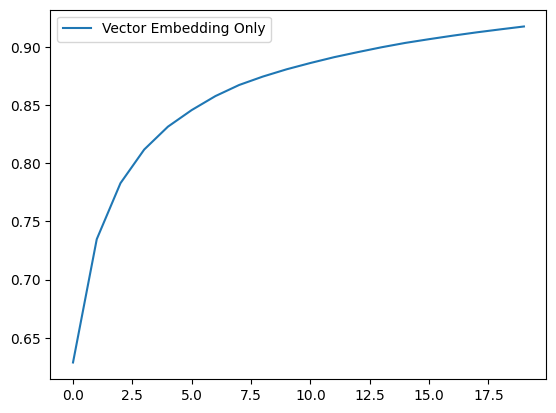

In [34]:
plt.plot(openai_embedding_recall_at_n, label="Vector Embedding Only")
plt.legend()
plt.show()

This means that if I only look at the top-1 paragraph, I will find the paragraph with the answer ~ 63% of the time. and this increases to 88% with the top 10 documents, and 91.7% for the top 20 documents. This seems pretty good!

# Classical Methods: BM25
How about if I use an old "classical" method that pretty much only works with simple word frequencies. BM25. This is basically tf-idf with some additional normalization tricks and see how it performs! BM25 requires us to first tokenize the documents, and here we just use the Spacy library.

In [35]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.9 MB/s eta 0:00:00m eta 0:00:010:0101
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [36]:
from rank_bm25 import BM25Okapi
import concurrent
import bm25_helpers

In [37]:
%%xetmemo input=all_paragraphs output=tokenized_corpus
tokenized_corpus = [bm25_helpers.tokenize(par) for par in all_paragraphs]

Loading from 2943cba8dd9262e61ddb52e4f10a7dfb33f46e3d7c18bf5e796fb0cec11fc0e4.pickle


In [38]:
# We do a little bit more normalization post-tokenization by lower-casing all words and dropping punctuation.
tokenized_corpus = [[word.lower() for word in doc if word.isalpha()] for doc in tokenized_corpus]
k = 50

In [39]:
%%xetmemo input=tokenized_corpus,k output=bm25_nearest_paragraphs
bm25 = BM25Okapi(tokenized_corpus)
bm25_nearest_paragraphs = []
futures = []
nworkers = 8
with concurrent.futures.ProcessPoolExecutor(max_workers=nworkers) as executor:
    for s in range(nworkers):
        start = (s * len(all_qa)) // nworkers
        end = ((s + 1) * len(all_qa)) // nworkers
        if s == nworkers - 1:
            end = len(all_qa)
        futures.append(executor.submit(bm25_helpers.get_bm25_top_k_batch, 
                                       bm25, 
                                       [qa[1].lower() for qa in all_qa[start:end]], 
                                       k))

    for future in futures:
        bm25_nearest_paragraphs.extend(future.result())
        print(len(bm25_nearest_paragraphs))


10852
21705
32557
43410
54263
65115
75968
86821


In [40]:
bm25_nearest_paragraphs = np.array(bm25_nearest_paragraphs)
bm25_p_at = []
bm25_p_at.append((bm25_nearest_paragraphs[:,0] == truth).sum())
for i in range(1,20):
    p = (bm25_nearest_paragraphs[:,i] == truth).sum()
    bm25_p_at.append(bm25_p_at[i-1] + p)

In [41]:
bm25_embedding_recall_at_n = np.array(bm25_p_at) / len(nearest_paragraphs)
bm25_embedding_recall_at_n

array([0.64513194, 0.73759805, 0.77885535, 0.80414877, 0.82131051,
       0.83369231, 0.8434365 , 0.85175246, 0.85896269, 0.86511328,
       0.87073404, 0.87482291, 0.87930339, 0.88287396, 0.88634086,
       0.88946223, 0.89205377, 0.89440343, 0.89707559, 0.89927552])

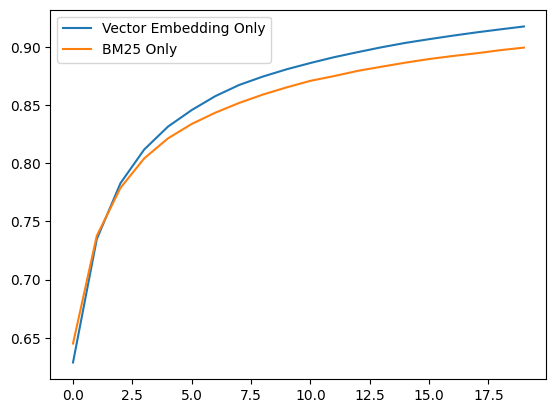

In [42]:
plt.plot(openai_embedding_recall_at_n, label="Vector Embedding Only")
plt.plot(bm25_embedding_recall_at_n, label="BM25 Only")
plt.legend()
plt.show()

BM25 as a simpler model does not seem to perform better (though interestingly it appears better at top 1). That said, it is not much worse. In fact, if we were to consider how we might want to evaluate RAG in practice: to begin with the end metric in mind. If we say we are targetting a retrieval accuracy of 85%. Then if we were to use a vector database, I would need to fetch 7 documents. If I were to use BM25 only, I would need to fetch 8 documents. The real practical difference here is insignificant, considering the cost of maintaining a vector database as well as an embedding service.

# Reranking BM25 with Vectors
If we return to how Information Retrieval is classically implemented to support IR on billions of documents. The standard solutions are to begin with very efficient, low precision, high recall algorithms that can quickly sift through billions of documents and reduce it to a smaller subset of ~1000 docs. After which more expensive algorithms which are more precise are then used to rerank and reduce the document set to find a small set of documents which are truly relevant. 

We can use the same principle here. BM25 is a generally inexpensive method that can be efficiently implemented with reverse index solutions to rapidly sift down to a moderately sized dataset. After which, vector embeddings are the higher precision approach which we can use to rerank the dataset. 

Here, we simply rerank the top-50 results from BM25 using nearest neighbors from the vector embeddings:

In [43]:
bm25_nearest_paragraphs_reranked = []
for i in range(bm25_nearest_paragraphs.shape[0]):
    paragraphs = bm25_nearest_paragraphs[i,:]
    qn_vec = qn_embeddings[i,:]
    par_vecs = par_embeddings[paragraphs,:]
    distances = np.sum((par_vecs - qn_vec)**2,axis=1)
    bm25_nearest_paragraphs_reranked.append(paragraphs[np.argsort(distances)])

In [44]:
bm25_nearest_paragraphs_reranked = np.array(bm25_nearest_paragraphs_reranked)

In [45]:
bm25_p_at_reranked = []
bm25_p_at_reranked.append((bm25_nearest_paragraphs_reranked[:,0] == truth).sum())
for i in range(1,20):
    p = (bm25_nearest_paragraphs_reranked[:,i] == truth).sum()
    bm25_p_at_reranked.append(bm25_p_at_reranked[i-1] + p)
bm25_embedding_reranked_recall_at_n = np.array(bm25_p_at_reranked) / len(nearest_paragraphs)
bm25_embedding_reranked_recall_at_n

array([0.65493371, 0.76445791, 0.81156633, 0.83843771, 0.85591044,
       0.86878751, 0.87824374, 0.8860414 , 0.8919501 , 0.89711015,
       0.90142938, 0.90486173, 0.90781032, 0.91052856, 0.9131201 ,
       0.91507815, 0.91686343, 0.9185105 , 0.91997328, 0.92121722])

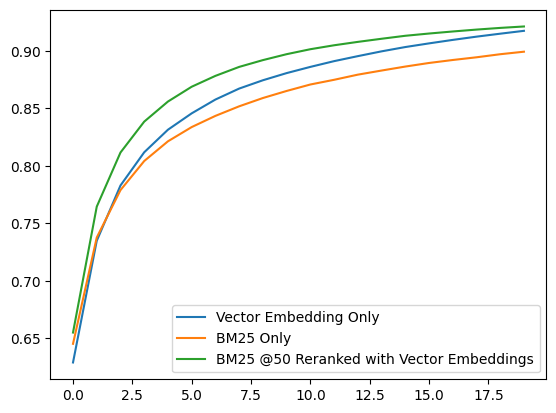

In [46]:
plt.plot(openai_embedding_recall_at_n, label="Vector Embedding Only")
plt.plot(bm25_embedding_recall_at_n, label="BM25 Only")
plt.plot(bm25_embedding_reranked_recall_at_n, label="BM25 @50 Reranked with Vector Embeddings")
plt.legend()
plt.show()

And this simply cleanly outperform everything. Even with if you have vector embeddings, all you really need is a vector retrieval service to be able to do efficient k-NN reranking on a small set of vectors. No vector database necessary.